In [48]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
#import squarify
%matplotlib inline
#import missingno as msno
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template

In [7]:
## For now, only loading 10,000,000 rows to speed up import

items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
# Read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
train = pd.read_csv("train.csv", nrows=10000000, parse_dates=['date'])

# Inspecting train.csv

In [8]:
# Visually inspect train.csv data
train.head()

## See that onpromotion contains many NaN values
## NaN probably means No
## Data appears tidy
    # 1) Columns represent separate variables
    # 2) Rows represent individual observations
    # 3) Observational units form tables
    


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [9]:
train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
9999995,9999995,2013-08-21,1,999547,12.0,NaN
9999996,9999996,2013-08-21,1,1001305,3.0,NaN
9999997,9999997,2013-08-21,1,1004550,15.0,NaN
9999998,9999998,2013-08-21,1,1004551,25.0,NaN
9999999,9999999,2013-08-21,1,1009512,1.0,NaN


In [10]:
train.info()
## no count of non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
id             int64
date           datetime64[ns]
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 457.8 MB


In [12]:
train.describe()
## Summary stats not really meaningful in this context

,id,store_nbr,item_nbr,unit_sales,onpromotion
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,0.0
mean,5.000000e+06,2.667514e+01,6.395430e+05,8.469736e+00,NaN
std,2.886751e+06,1.645435e+01,3.145499e+05,1.847005e+01,NaN
min,0.000000e+00,1.000000e+00,9.699500e+04,-2.070000e+02,NaN
25%,2.500000e+06,1.100000e+01,3.607050e+05,2.000000e+00,NaN
50%,5.000000e+06,2.700000e+01,6.410420e+05,4.000000e+00,NaN
75%,7.499999e+06,4.300000e+01,9.069790e+05,9.000000e+00,NaN
max,9.999999e+06,5.400000e+01,1.168738e+06,1.007400e+04,NaN


In [13]:
print(train.shape)
## Train contains 10 million rows (as expected),  but only 6 columns

(10000000, 6)


In [15]:
## Frequency counts by store
train.store_nbr.value_counts(dropna=False).head()

44    301227
45    295495
47    293893
3     290564
46    282917
Name: store_nbr, dtype: int64

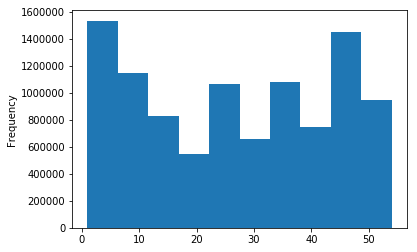

In [17]:
train.store_nbr.plot('hist')
# No clear grouping of store number by transaction count

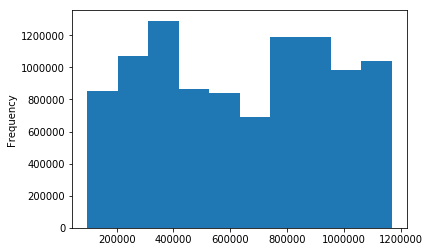

In [18]:
train.item_nbr.plot('hist')

In [21]:
train_pivot_unitsales_by_day = train.pivot_table(index=['date'], values='unit_sales')

In [22]:
train_pivot_unitsales_by_day.head()

,unit_sales
date,
2013-01-01,4.345362
2013-01-02,11.903552
2013-01-03,9.013198
2013-01-04,8.850871
2013-01-05,11.222789


In [23]:
# drop duplicates
train_no_duplicates = train.drop_duplicates()

In [24]:
train_no_duplicates.info()
# no duplicates were detected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
id             int64
date           datetime64[ns]
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 534.1 MB


# Inspecting oil.csv


In [25]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [26]:
oil.tail()
# immediately see that oil hald as expensive in 2017 than in 2013

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [27]:
oil.info()
# missing oil data in about 43 rows
# date column is object type, not datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null object
dcoilwtico    1175 non-null float64
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


In [28]:
print(oil.shape)

(1218, 2)


In [38]:
type(oil.date)
oil.set_index(pd.DateTimeIndex(oil['date']))

AttributeError: module 'pandas' has no attribute 'DateTimeIndex'

TypeError: unhashable type: 'numpy.ndarray'

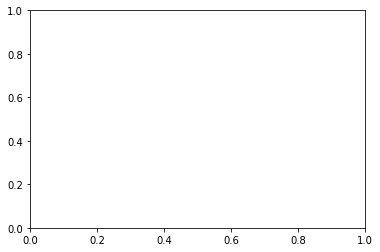

In [37]:
plt.plot(oil)

In [50]:
trace = go.Scatter(
    name='Oil prices',
    x=oil['date'],
    y=oil['dcoilwtico'].dropna(),
    mode='lines',
    line=dict(color='rgb(20, 15, 200, 0.8)'),
    #fillcolor='rgba(68, 68, 68, 0.3)',
    fillcolor='rgba(0, 0, 216, 0.3)',
    fill='tonexty' )

data = [trace]

layout = go.Layout(
    yaxis=dict(title='Daily Oil price'),
    title='Daily oil prices from Jan 2013 till July 2017',
    showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')

NameError: name 'go' is not defined